In [1]:
using JuMP, Ipopt, Plots
using Images, QuartzImageIO, ImageView


(process:3020): Gtk-WARNING **: 12:04:46.092: Locale not supported by C library.
	Using the fallback 'C' locale.


In [2]:
dynopt_batch = Model(solver=IpoptSolver());

In [3]:
np       = 1:1200        # number of discretization points
t        = 200+273.16   # K
a1       = 0.7e1        # L/(mol-min)
e1       = 2000         # cal/mol
a2       = 2.5e02       # 1/min
e2       = 9500         # cal/mol
rgas     = 1.987        # cal/(mol-K)
v        = 5000         # L

t0       = 0            # initial time [min]
tf       = 20*60        # end time
na_init  = 100          # Number of initial moles of compound A
nb_init  = 0            # Number of initial moles of compound B
nc_init  = 0            # Number of initial moles of compound C

0

In [4]:
time  = Array{Float64}(undef, length(np))
w     = Array{Float64}(undef, length(np))
dt    = (tf-t0)/(length(np)-1)
for i = 1:length(np)
   time[i] = t0+(i-1)*dt
end
w[1] = 1
w[length(np)] = 1;
for i = 2:length(np)-1
    w[i] = 2
    if mod(i,2) == 0
       w[i] = 3
    end
end

In [5]:
@variable(dynopt_batch, 0      <= na[np]  <= na_init,    start = 0.5*na_init)
@variable(dynopt_batch,           nb[np]  >= 0      ,    start = 0.5*na_init)
@variable(dynopt_batch,           nc[np]  >= 0      ,    start = 0.5*na_init);

In [6]:
@constraint(dynopt_batch, icond_na, na[1] == na_init)
@constraint(dynopt_batch, icond_nb, nb[1] == nb_init)
@constraint(dynopt_batch, icond_nc, nc[1] == nc_init);

In [7]:
@NLconstraint(dynopt_batch, dynmodel_na[i in 2:length(np)], 
  na[i] == na[i-1] + dt*( -a1*exp(-e1/(rgas*t))*(na[i]/v)^2*v ) ) ;

In [8]:
@NLconstraint(dynopt_batch, dynmodel_nb[i in 2:length(np)], 
  nb[i] == nb[i-1] + dt*( a1*exp(-e1/(rgas*t))*(na[i]/v)^2*v - a2*exp(-e2/(rgas*t))*(nb[i]/v)*v   ) ) ;

In [9]:
@NLconstraint(dynopt_batch, dynmodel_nc[i in 2:length(np)], 
  nc[i] == nc[i-1] + dt*( a2*exp(-e2/(rgas*t))*(nb[i]/v)*v ) ) ;

In [10]:
@NLobjective(dynopt_batch, Max, 1 );

In [11]:
status_dynopt_batch = solve(dynopt_batch);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     9595
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2398

Total number of variables............................:     3600
                     variables with only lower bounds:     2400
                variables with lower and upper bounds:     1200
                     variables with only upper bounds:        0
Total number of equ

In [12]:
println("Objective function value = ", getobjectivevalue(dynopt_batch))

Objective function value = 1.0


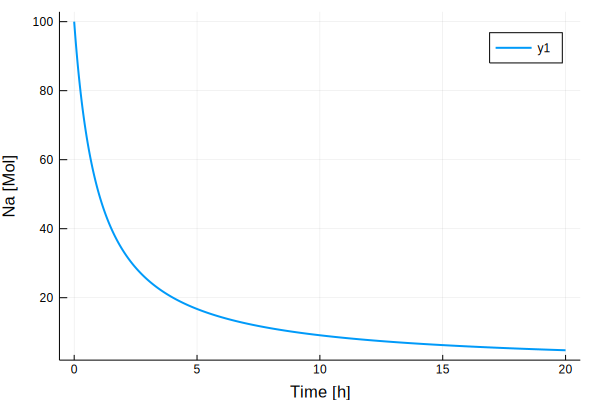

In [13]:
timep    = Array{Float64}(undef, length(np))                
nap      = Array{Float64}(undef, length(np))                
nbp      = Array{Float64}(undef, length(np))                
ncp      = Array{Float64}(undef, length(np))                

for i = 1:length(np)
    timep[i] = time[i]/60
    nap[i]   = getvalue(na[i])   
    nbp[i]   = getvalue(nb[i])   
    ncp[i]   = getvalue(nc[i])   
end    

plot(timep,nap,lw=2,xlabel="Time [h]",ylabel="Na [Mol]")

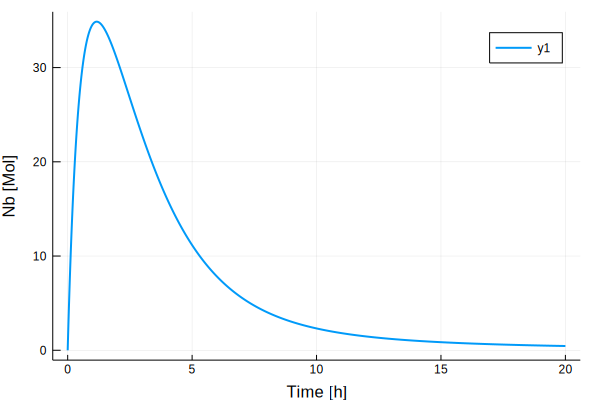

In [14]:
plot(timep,nbp,lw=2,xlabel="Time [h]",ylabel="Nb [Mol]")

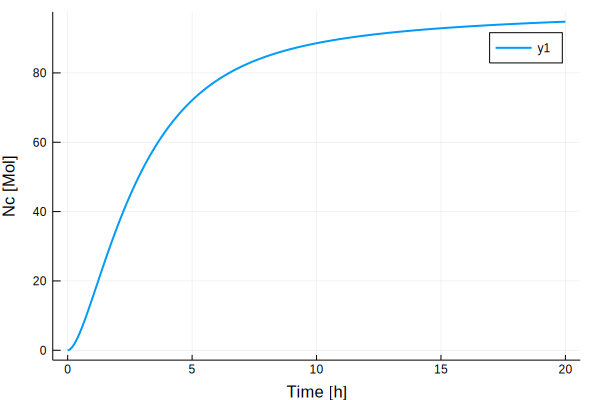

In [15]:
plot(timep,ncp,lw=2,xlabel="Time [h]",ylabel="Nc [Mol]")